# Learning to predict

Now that we have our dataset, let's learn to predict bots!

## Useful imports and functions

As always, let's start by importing the packages we need. Afterall, that's how Python works, isn't it? You want something, there's a package for it...

[![Python by xkcd](http://imgs.xkcd.com/comics/python.png)](http://xkcd.com/353/)

In [1]:
# Data manipulation
import pickle
import pandas as pd
import numpy as np

# Machine Learning
import sklearn
import sklearn.ensemble
import sklearn.svm
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['figure.figsize'] = 8, 5.5

# Utility functions

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Plot a confusion matrix
def plotConfMap(confMat, classes=[], relative=False):

    width = len(confMat)
    height = len(confMat[0])
    
    oldParams = rcParams['figure.figsize']
    rcParams['figure.figsize'] = width, height
    
    fig = plt.figure()
    plt.clf()
    plt.grid(False)
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    
    if not relative:
        res = ax.imshow(confMat, cmap='coolwarm', interpolation='nearest')
    else:
        res = ax.imshow(confMat, cmap='coolwarm', interpolation='nearest', vmin=0, vmax=100)

    for x in xrange(width):
        for y in xrange(height):
            ax.annotate(str(np.round(confMat[x][y], 1)), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')

    fig.colorbar(res)
    
    if len(classes) > 0:
        plt.xticks(range(width), classes)
        plt.yticks(range(height), classes)

    rcParams['figure.figsize'] = oldParams
    
    return fig

# Plot CV scores of a 2D grid search
def plotGridResults2D(x, y, x_label, y_label, grid_scores):
    
    scores = [s[1] for s in grid_scores]
    scores = np.array(scores).reshape(len(x), len(y))

    plt.figure()
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.RdYlGn)
    plt.xlabel(y_label)
    plt.ylabel(x_label)
    plt.colorbar()
    plt.xticks(np.arange(len(y)), y, rotation=45)
    plt.yticks(np.arange(len(x)), x)
    plt.title('Validation accuracy')

# Plot CV scores of a 1D "grid" search (a very narrow "grid")
def plotGridResults1D(x, x_label, grid_scores):
    
    scores = np.array([s[1] for s in grid_scores])
    
    plt.figure()
    plt.plot(scores)
    plt.xlabel(x_label)
    plt.ylabel('Score')
    plt.xticks(np.arange(len(x)), x, rotation=45)
    plt.title('Validation accuracy')

## Load and split dataset

First, let's load the dataset from our pickle file and split it into 3 sets:

* **learn** for the learning phase, split into:
    * **train** for the training (will be used as validation with CV too)
    * **test** to evaluate the results
* **final** for the final prediction, the one we will send to Kaggle

In [2]:
# Load
X_ids, X, y = pickle.load(open('Xy.pkl', 'rb'))
y = y.reshape(y.shape[0])
X_ids = np.array(X_ids)

# Split learn and final with outcome indices
i_final = (y == -1)
i_learn = (y > -1)

X_ids_final = X_ids[i_final]
X_ids_learn = X_ids[i_learn]
X_final = X[i_final, :]
X_learn = X[i_learn, :]
y_learn = y[i_learn]

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X_learn, y_learn, test_size=.25)

## RBF SVM

Having been taught Machine Learning in a large part by a [researcher in SVM and kernel methods](http://asi.insa-rouen.fr/enseignants/~scanu/), my first Machine Learning try on a problem is often to use a SVM.

### Tuning the hyperparameters

To optimize the hyperparameters of my SVM, I'm going to do a double step grid search, first looking at the optimal value on a coarse grid, and then on a more fine grid around a promising area. You can actually do this a lot better, and especially you can accelerate the coarse grid a lot (that's supposed to be the idea of it being coarse) for example by using a subset of the dataset. Here we might have dropped a lot of non-bots bidders I think. But anyway, that's how it is...

One important thing is of course to think about finding the optimal value considering the AUC a scoring metrics, and not the classification rate. This obviously increase a lot your performance.

I chose to use 10 CV because my "bot" class contains really not a lot of values and I don't want to drop to much of them in the test fold.

/usr/local/lib/python2.7/site-packages/sklearn/svm/base.py:209: ConvergenceWarning: Solver terminated early (max_iter=60000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/sklearn/svm/base.py:209: ConvergenceWarning: Solver terminated early (max_iter=60000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/sklearn/svm/base.py:209: ConvergenceWarning: Solver terminated early (max_iter=60000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/sklearn/svm/base.py:209: ConvergenceWarning: Solver terminated early (max_iter=60000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/sklearn/svm/b

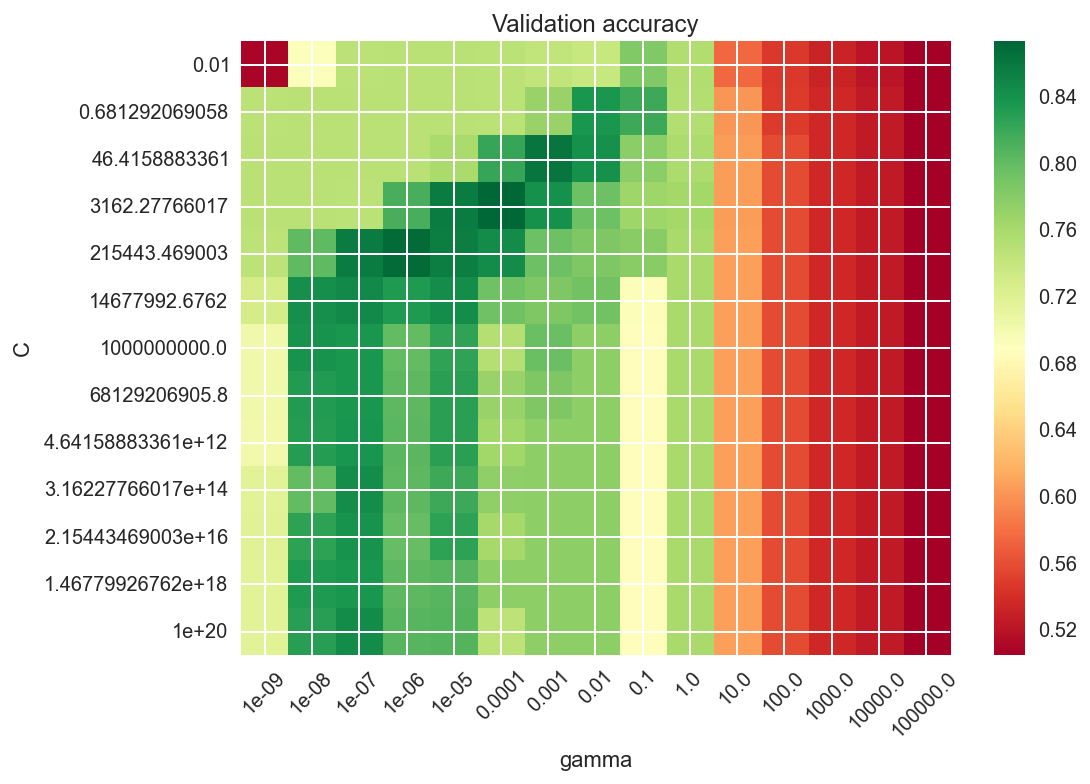

best C coarse: 4.0
best gamma coarse: -4.0
SVC(C=517.94746792312128, cache_size=200, class_weight='auto', coef0=0.0,
  degree=3, gamma=0.00043939705607607906, kernel='rbf', max_iter=60000,
  probability=True, random_state=None, shrinking=True, tol=0.001,
  verbose=False)


/usr/local/lib/python2.7/site-packages/sklearn/svm/base.py:209: ConvergenceWarning: Solver terminated early (max_iter=60000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/sklearn/svm/base.py:209: ConvergenceWarning: Solver terminated early (max_iter=60000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/sklearn/svm/base.py:209: ConvergenceWarning: Solver terminated early (max_iter=60000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/sklearn/svm/base.py:209: ConvergenceWarning: Solver terminated early (max_iter=60000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/sklearn/svm/b

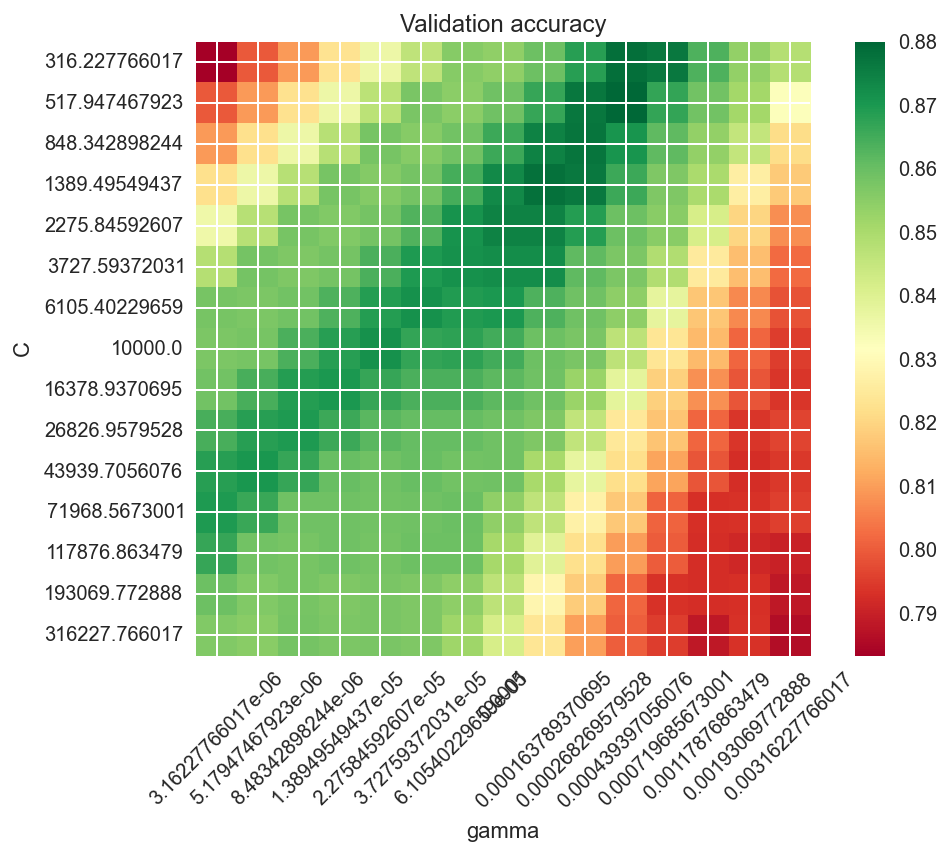

In [3]:
# Coarse grid
C_range = np.r_[np.logspace(-2, 20, 13)]
gamma_range = np.r_[np.logspace(-9, 5, 15)]
grid = GridSearchCV(sklearn.svm.SVC(C=1.0, kernel='rbf', class_weight='auto', verbose=False, max_iter=60000),
                    {'C' : C_range, 'gamma': gamma_range},
                   scoring='roc_auc', cv=10, n_jobs=8)
grid.fit(X_learn, y_learn)

plotGridResults2D(C_range, gamma_range, 'C', 'gamma', grid.grid_scores_)
plt.show()

# Display result
C_best = np.round(np.log10(grid.best_params_['C']))
gamma_best = np.round(np.log10(grid.best_params_['gamma']))
print 'best C coarse:', C_best
print 'best gamma coarse:', gamma_best

# Fine grid
C_range2 = np.r_[np.logspace(C_best - 1.5, C_best + 1.5, 15)]
gamma_range2 = np.r_[np.logspace(gamma_best - 1.5, gamma_best + 1.5, 15)]

gridFine = GridSearchCV(sklearn.svm.SVC(C=1.0, kernel='rbf', class_weight='auto', verbose=False, max_iter=60000),
                    {'C' : C_range2, 'gamma': gamma_range2},
                   scoring='roc_auc', cv=10, n_jobs=8)
gridFine.fit(X_learn, y_learn)

plotGridResults2D(C_range2, gamma_range2, 'C', 'gamma', gridFine.grid_scores_)

# Final result
bestClf = gridFine.best_estimator_
bestClf.probability = True
print bestClf

### Testing the model

Now that we have our CV-optimized hyperparameters, let's learn this classifier on the full train set and evaluate it on the test set.

             precision    recall  f1-score   support

        0.0       0.97      0.82      0.89       464
        1.0       0.20      0.62      0.30        32

avg / total       0.92      0.81      0.85       496



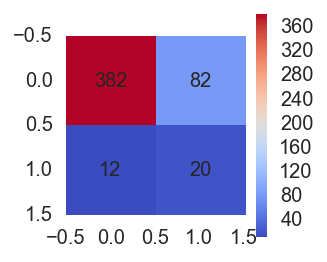

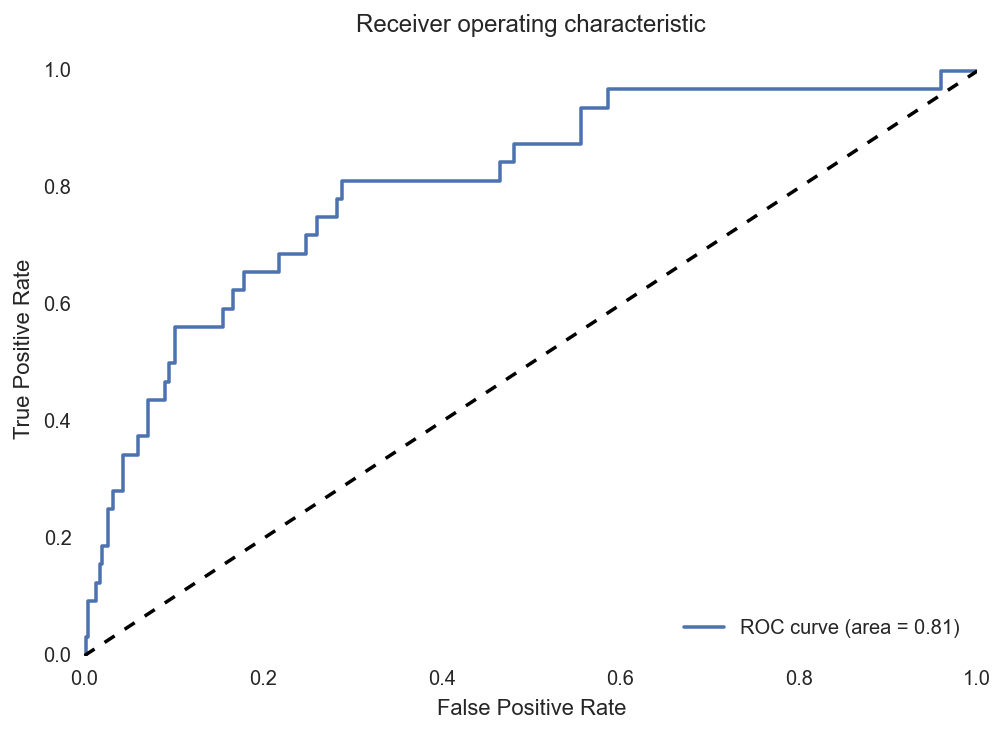

In [4]:
# Fit it
bestClf.fit(X_train, y_train)
y_pred = bestClf.predict(X_test)

# Classif report and conf mat
print sklearn.metrics.classification_report(y_test, y_pred)
plotConfMap(sklearn.metrics.confusion_matrix(y_test, y_pred))
plt.show()

# Predict scores
y_score = bestClf.decision_function(X_test) 

# Plot ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Final prediction

Ok, now let's make our final prediction, learing on the full learning set and prediction on the *final* set.

In [5]:
# Fit on learn set and predict final set
bestClf.fit(X_learn, y_learn)
y_final = bestClf.predict_proba(X_final)[:,1]

# Dirty join with test.csv to order them like it was before...
# ... now that I look at this I am quite sure that Kaggle don't need them in the right
# order so all this is actually pretty stupid. Sorry :)
bidders_y_final = pd.DataFrame(np.c_[X_ids[i_final], y_final], columns=['bidder_id', 'prediction'])
bidders_y_final[['prediction']] = bidders_y_final[['prediction']].astype(float)
bidders_list = pd.read_csv('test.csv', header=0)
bidders_list_final = pd.merge(bidders_list[['bidder_id']], bidders_y_final, how='left').fillna(0.0)

# Write results to file
f = open('predictions_RBF_SVM.csv', 'wb')
f.write(bidders_list_final.to_csv(index=False))
f.close()

## Linear L1 SVM

Because of all the categories we kept from bids (highest frequent category use by a bidder, for a few variables), we have a lot of binary features, so it makes sense to use some L1 regularization. However, scikit-learn's RBF SVM doesn't have this feature, and I was too lazy to implement it myself so I tried the linear L1 SVM of scikit-learn. Also I wanted to try linear SVM as well.

The code is basically the same as for RBF SVM.

### Tuning the hyperparameters

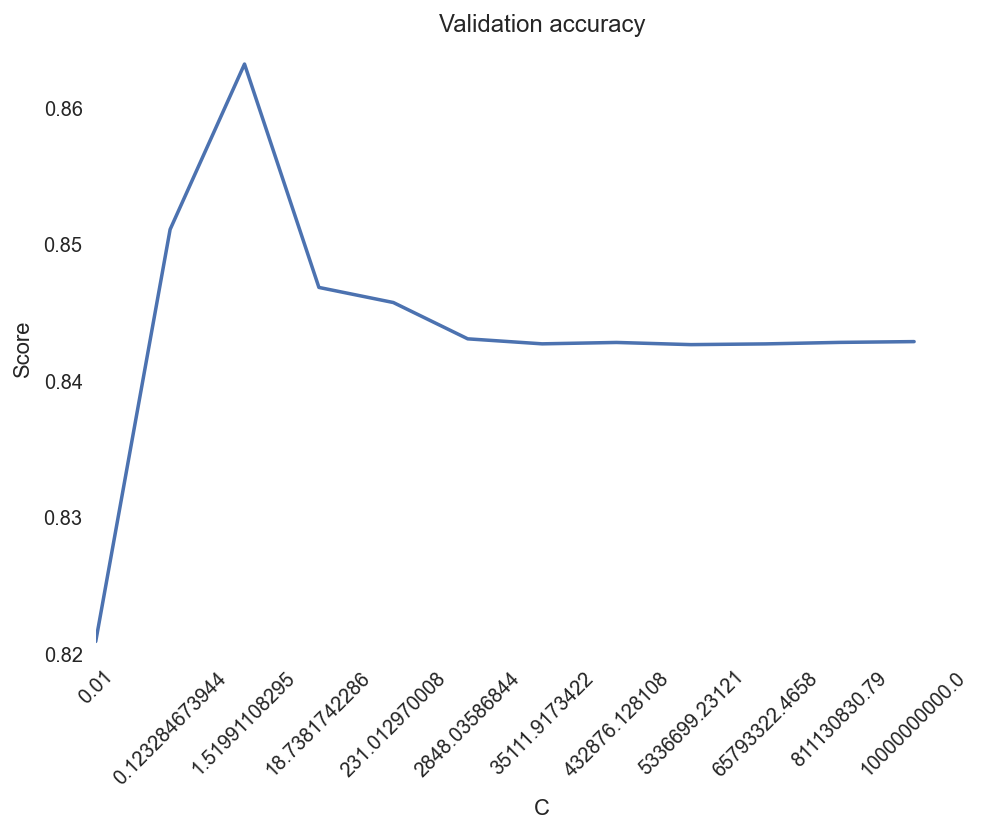

best C coarse: 0.0
LinearSVC(C=0.13894954943731375, class_weight='auto', dual=False,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=3000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=False)


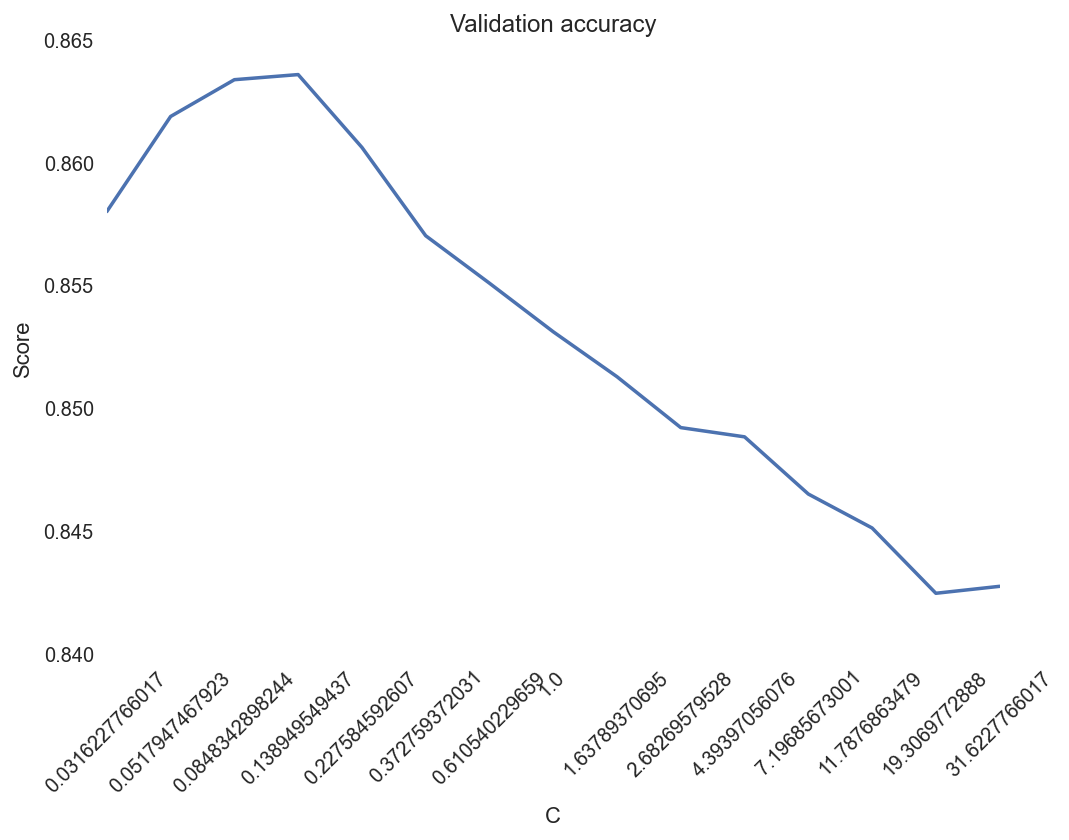

In [6]:
# Coarse grid
C_range = np.r_[np.logspace(-2, 10, 12)]
grid = GridSearchCV(sklearn.svm.LinearSVC(C=1.0, penalty='l1', class_weight='auto', dual=False, verbose=False, max_iter=3000),
                    {'C' : C_range},
                   cv=10, n_jobs=8, scoring='roc_auc')
grid.fit(X_learn, y_learn)

plotGridResults1D(C_range, 'C', grid.grid_scores_)
plt.show()

# Results
C_best = np.round(np.log10(grid.best_params_['C']))
print 'best C coarse:', C_best

# Fine grid
C_range2 = np.r_[np.logspace(C_best - 1.5, C_best + 1.5, 15)]

gridFine = GridSearchCV(sklearn.svm.LinearSVC(C=1.0, class_weight='auto', dual=False, verbose=False, max_iter=3000),
                    {'C' : C_range2},
                   cv=10, n_jobs=8, scoring='roc_auc')
gridFine.fit(X_learn, y_learn)

plotGridResults1D(C_range2, 'C', gridFine.grid_scores_)

# Final results
bestClf = gridFine.best_estimator_
bestClf.probability = True
print bestClf

### Testing the model

             precision    recall  f1-score   support

        0.0       0.98      0.80      0.88       464
        1.0       0.19      0.72      0.31        32

avg / total       0.93      0.79      0.84       496



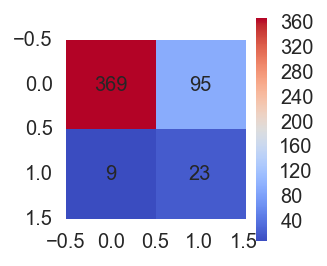

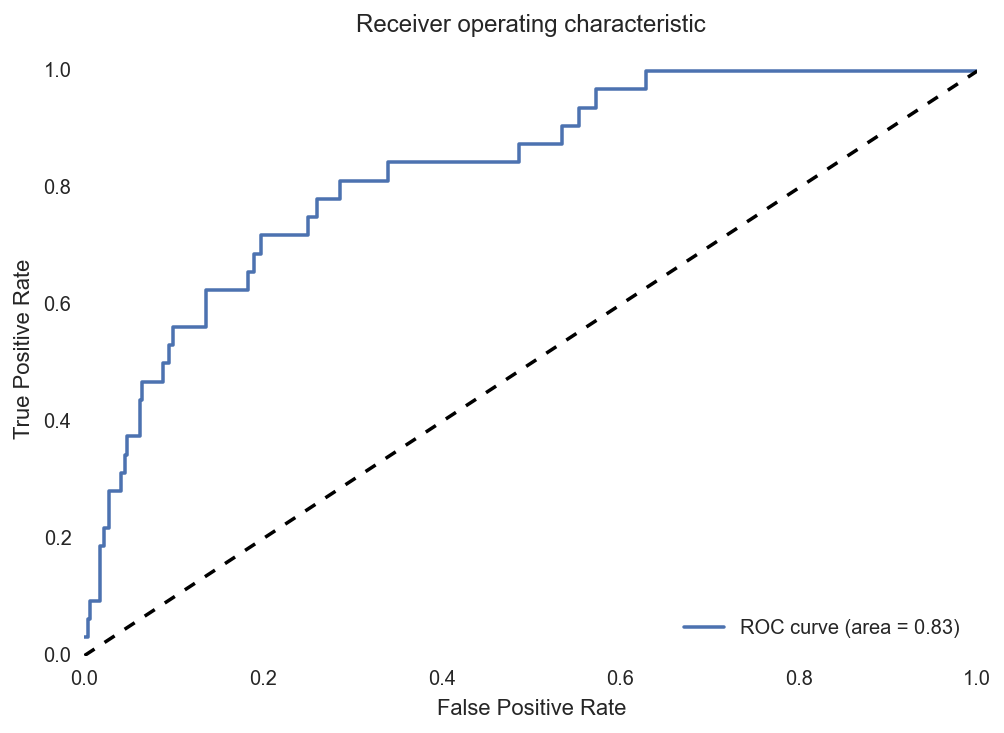

In [7]:
# Fit on train
bestClf.fit(X_train, y_train)
y_pred = bestClf.predict(X_test)

# Classification report
print sklearn.metrics.classification_report(y_test, y_pred)
plotConfMap(sklearn.metrics.confusion_matrix(y_test, y_pred))
plt.show()

# Predict
y_score = bestClf.decision_function(X_test) 

# Plot ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Final prediction

In [8]:
# Fit on learn
bestClf.fit(X_learn, y_learn)
y_final = bestClf.predict(X_final)

# Reorder prediction
bidders_y_final = pd.DataFrame(np.c_[X_ids[i_final], y_final], columns=['bidder_id', 'prediction'])
bidders_y_final[['prediction']] = bidders_y_final[['prediction']].astype(float)
bidders_list = pd.read_csv('test.csv', header=0)
bidders_list_final = pd.merge(bidders_list[['bidder_id']], bidders_y_final, how='left').fillna(0.0)

# Save to file
f = open('predictions_Lin_SVM_L1.csv', 'wb')
f.write(bidders_list_final.to_csv(index=False))
f.close()

## Random forest

Also a classifier well known to be great is the random forest. The problem is that it can have a lot of hyperparameters to tune. Basically all the parameters in the trees plus the ensemble settings such as number of estimators, but also random feature subspace size if you want, etc.

I chose to only CV grid search the number of estimators and the max depth of the tree. The idea of this code is again very close to the one of SVMs. But in this case I only used one grid search.

If I wanted a perfect there would definitely be things to factorize between those different classifiers (and scikit-learn is actually very good for this with their consistant interfaces across classifiers).

### Tuning the hyperparameters

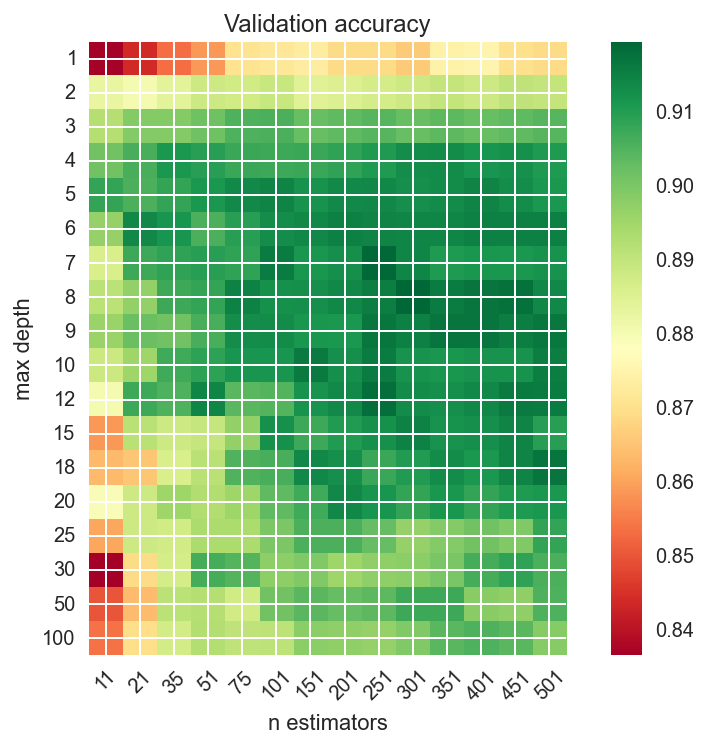

RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=301, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [9]:
# Coarse grid
HP_range = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 18, 20, 25, 30, 50, 100])
HP2_range = np.array([11, 21, 35, 51, 75, 101, 151, 201, 251, 301, 351, 401, 451, 501])
grid = GridSearchCV(sklearn.ensemble.RandomForestClassifier(n_estimators=300, max_depth=None,
                                                                   max_features='auto', class_weight='auto'),
                    {'max_depth' : HP_range,
                    'n_estimators' : HP2_range},
                   cv=sklearn.cross_validation.StratifiedKFold(y_learn, 5), n_jobs=8, scoring='roc_auc')
grid.fit(X_learn, y_learn)

plotGridResults2D(HP_range, HP2_range, 'max depth', 'n estimators', grid.grid_scores_)
plt.show()

# Final res
bestClf = grid.best_estimator_
print bestClf

### Testing the model

             precision    recall  f1-score   support

        0.0       0.94      1.00      0.97       464
        1.0       0.83      0.16      0.26        32

avg / total       0.94      0.94      0.93       496



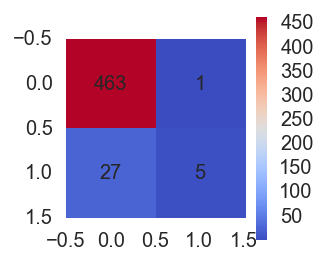

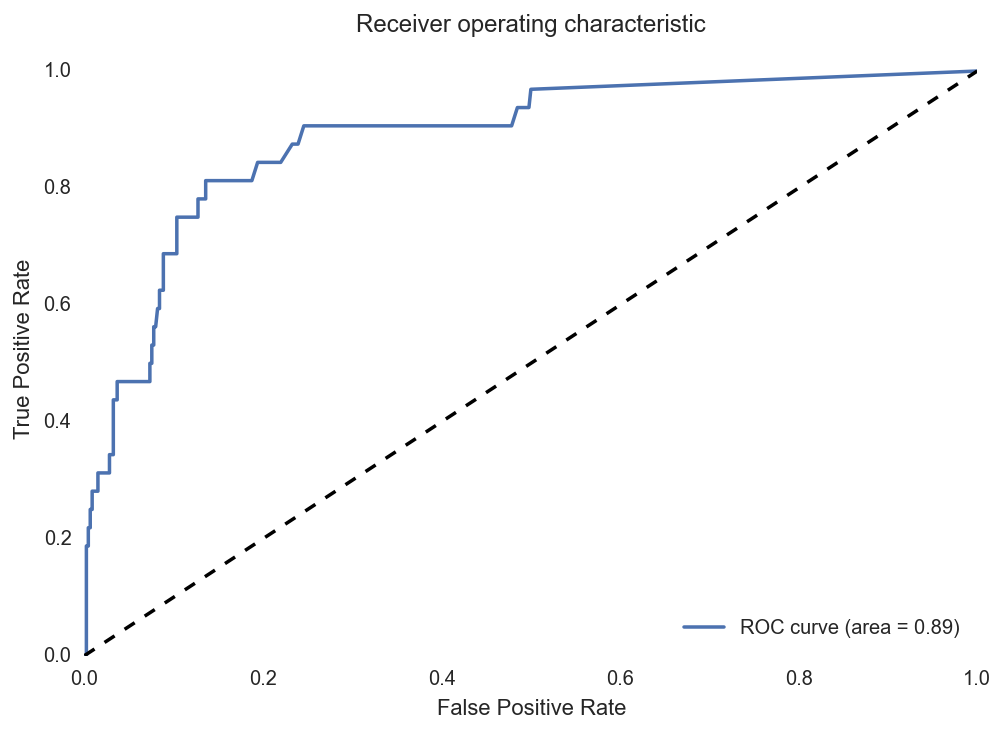

In [10]:
# Ok, I actally want to choose these paramters myself! I'm god here, I do what I want!
bestClf = sklearn.ensemble.RandomForestClassifier(max_depth=20, n_estimators=301,
                                        max_features='auto', class_weight='auto')

# Learn on train for test
bestClf.fit(X_train, y_train)
y_pred = bestClf.predict(X_test)

# Classification report
print sklearn.metrics.classification_report(y_test, y_pred)
plotConfMap(sklearn.metrics.confusion_matrix(y_test, y_pred))
plt.show()

# Predict scores
y_score = bestClf.predict_proba(X_test)[:,1]

# ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [11]:
bestClf.fit(X_learn, y_learn)
y_final = bestClf.predict_proba(X_final)[:,1]

bidders_y_final = pd.DataFrame(np.c_[X_ids[i_final], y_final], columns=['bidder_id', 'prediction'])
bidders_y_final[['prediction']] = bidders_y_final[['prediction']].astype(float)
bidders_list = pd.read_csv('test.csv', header=0)
bidders_list_final = pd.merge(bidders_list[['bidder_id']], bidders_y_final, how='left').fillna(0.0)

f = open('predictions_RF_2.0.csv', 'wb')
f.write(bidders_list_final.to_csv(index=False))
f.close()

## AdaBoost

Ok I also tried AdaBoost which is also a nice ensemble technique but it didn't gave particularly better results than random forest. I think you got the idea of my code so I spare you the code for AdaBoost...

# Conclusion

I finally submitted predictions of my random forest for evaluation on the private leaderboard. I think this competition was more about feature engeneering than the pure Machine Learning part.

There are a lot of things I could have improved in my work. First, I could have used more complex features. Some good examples can be found for example on Kaggle's forum of the competition ["share your secret sauce" thread](https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot/forums/t/14628/share-your-secret-sauce), or other similar threads. I think more complex time series analysis could have been done on bids times. I did not tried to clean the dataset, but I think that removing some wierd points from the training dataset might have been a good thing. Also I think there might be interesting ways to deal with the imbalance of the dataset (other than class weighting that I did of course), but I didn't found time to dig into this. Finally regarding the pure Machine Learning part, using ensemble of different classifiers like some people did could also have improved the results.

Anyway, I am quite surprised of the good results I got with so simple features and model compared to what some other people did.